In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the dataset
import pandas as pd

df = pd.read_csv('../pokedex_(Update_05.20).csv')
#Dataset available at: https://www.kaggle.com/mariotormo/complete-pokemon-dataset-updated-090420?select=pokedex_%28Update_05.20%29.csv
#df.head()

In [ ]:
#Remove columns with names and non-important data
df.drop(["Unnamed: 0", "name", "german_name", "japanese_name", "species", "type_number", "ability_1", "ability_2", "ability_hidden", "egg_type_number"], axis=1, inplace=True)
#df.head()


- pokedex_number: The entry number of the Pokemon in the National Pokedex
- generation: The numbered generation which the Pokemon was first introduced
- status: Denotes if the Pokemon is normal, sub legendary, legendary or mythical
- type_1: The Primary Type of the Pokemon
- type_2: The Secondary Type of the Pokemon if it has it
- height_m: Height of the Pokemon in meters
- weight_kg: The Weight of the Pokemon in kilograms
- abilities_number: The number of abilities of the Pokemon
- total_points: Total number of Base Points
- hp: The Base HP of the Pokemon
- attack: The Base Attack of the Pokemon
- defense: The Base Defense of the Pokemon
- sp_attack: The Base Special Attack of the Pokemon
- sp_defense: The Base Special Defense of the Pokemon
- speed: The Base Speed of the Pokemon
- catch_rate: Catch Rate of the Pokemon
- base_friendship: The Base Friendship of the Pokemon
- base_experience: The Base experience of a wild Pokemon when caught
- growth_rate: The Growth Rate of the Pokemon
- egg_type_?: Names of the egg groups where a Pokemon can hatch
- percentage_male: The percentage of the species that are male. Blank if the Pokemon is genderless.
- egg_cycles: The number of cycles (255-257 steps) required to hatch an egg of the Pokemon
- against_?: Eighteen features that denote the amount of damage taken against an attack of a particular type

In [ ]:
#Replace the remaining textual data with categorical
type_1_list = list(set(df.type_1.tolist()))
type_2_list = list(set(df.type_2.tolist()))
growth_rate_list = list(set(df.growth_rate.tolist()))
egg_type_1_list = list(set(df.egg_type_1.tolist()))
egg_type_2_list = list(set(df.egg_type_2.tolist()))

df.status.replace(["Normal", "Sub Legendary", "Legendary", "Mythical"], [0, 1, 2, 3], inplace=True)
df.type_1.replace(type_1_list, range(len(type_1_list)), inplace=True)
df.type_2.replace(type_2_list, range(len(type_2_list)), inplace=True)
df.growth_rate.replace(growth_rate_list, range(len(growth_rate_list)), inplace=True)
df.egg_type_1.replace(egg_type_1_list, range(len(egg_type_1_list)), inplace=True)
df.egg_type_2.replace(egg_type_2_list, range(len(egg_type_2_list)), inplace=True)

df.dropna(inplace=True)

In [ ]:
#Divide the dataset in two sets: one for training and one for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['attack'], axis=1), df['attack'], test_size=0.3, random_state=42)
#y_train and y_test have the 'attack' column

In [ ]:
#Import the necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor


#Create the pipelines
linearReg_pipeline = make_pipeline(LinearRegression())
ridge_pipeline = make_pipeline(Ridge(alpha=1.0))
lasso_pipeline = make_pipeline(Lasso())
lassolars_pipeline = make_pipeline(LassoLars(alpha=0.01))
lassolars2_pipeline = make_pipeline(LassoLars(alpha=0.5))
elastic100_pipeline = make_pipeline(ElasticNet(max_iter=100, random_state=0))
elastic_pipeline = make_pipeline(ElasticNet(random_state=0))
passive100_pipeline = make_pipeline(PassiveAggressiveRegressor(max_iter=100, random_state=0))
passive_pipeline = make_pipeline(PassiveAggressiveRegressor(random_state=0))
rf_pipeline = make_pipeline(RandomForestRegressor(random_state=42))

estimators = [('Linear Regression', linearReg_pipeline),
              ('Ridge', ridge_pipeline),
              ('Lasso', lasso_pipeline),
              ('LassoLars 0.01', lassolars_pipeline),
              ('LassoLars 0.5', lassolars2_pipeline),
              ('ElasticNet 100', elastic100_pipeline),
              ('ElasticNet 1000', elastic_pipeline),
              ('Passive-Agressive Regressor 100', passive100_pipeline),
              ('Passive-Agressive Regressor 1000', passive_pipeline),
              ('Random Forest Regressor', rf_pipeline)]

#Stack the regressors using an ensemble method              
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

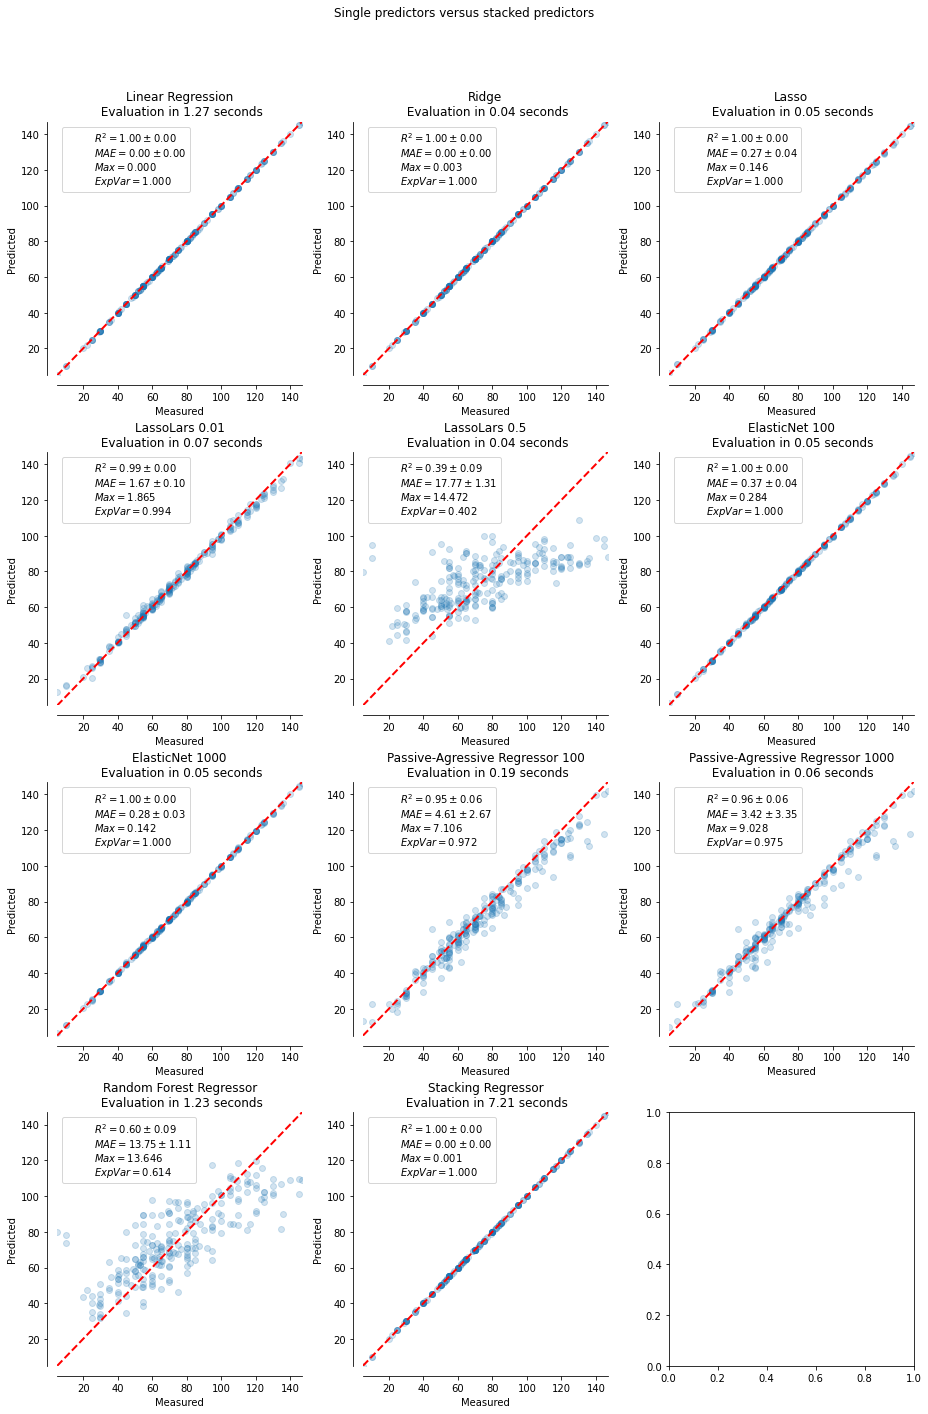

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import max_error
from sklearn.model_selection import cross_validate, cross_val_predict

def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(4, 3, figsize=(13, 20))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X_test, y_test,
                           scoring=['r2', 'neg_mean_absolute_error', 'max_error', 'explained_variance'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_test, y_test, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y_test, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$' + '\n' + r'$Max={:.3f}$' + '\n' + r'$ExpVar={:.3f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error']),
                np.std(score['test_max_error']),
                np.mean(score['test_explained_variance'])
                ),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

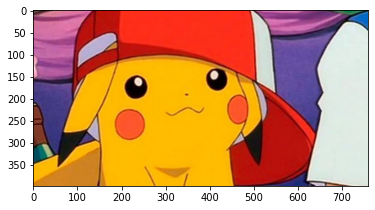

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.imshow(mpimg.imread('drive/MyDrive/Mestrado UFF/Inteligência Artificial/Trabalho_3_ML/Pikachu_hat.jpeg'))